In [1]:
import pickle
# goal_set.p 파일에서 데이터 불러오기
file_path = 'goal_set.p'
with open(file_path, 'rb') as f:
    data = pickle.load(f)



FileNotFoundError: [Errno 2] No such file or directory: 'goal_set.p'

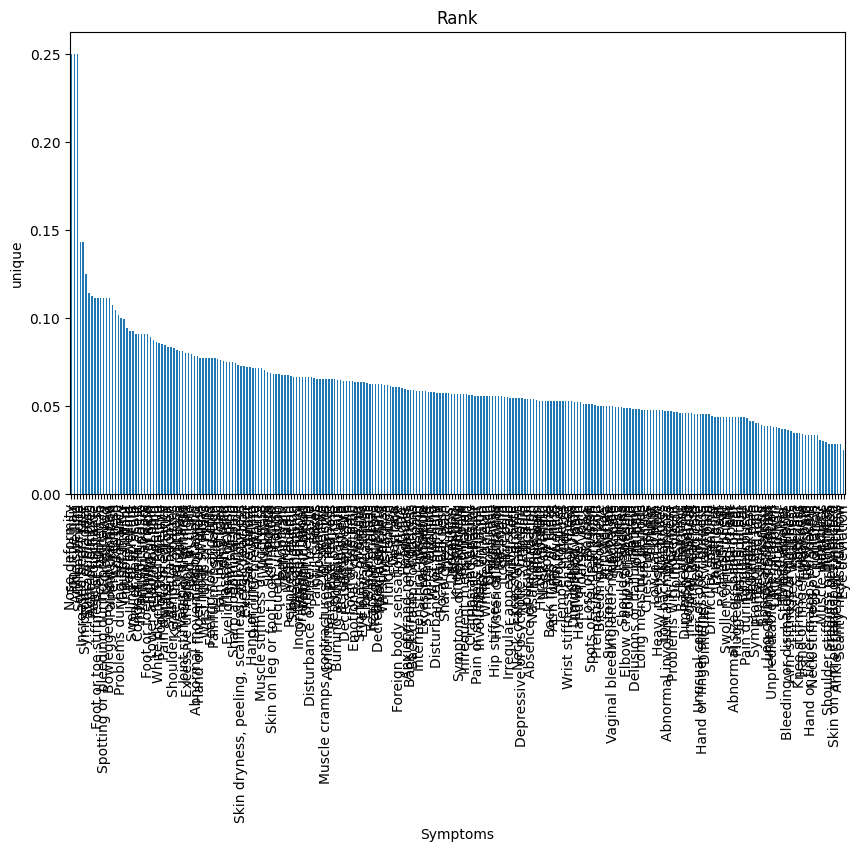

In [31]:
# 유니크함을 통해 증상들의 순위를 매겨 시각화.
import pandas as pd

# 훈련 데이터셋에서 증상별 빈도수 계산
symptom_counts = {}
for row in train_data:
    for symptom in row['goal']['explicit_inform_slots']:
        symptom_counts[symptom] = symptom_counts.get(symptom, 0) + 1

# 증상이 속한 질병의 수 계산
symptom_disease_counts = {}
for row in train_data:
    diseases = row['disease_tag']
    for symptom in row['goal']['explicit_inform_slots']:
        symptom_disease_counts[symptom] = symptom_disease_counts.get(symptom, 0) + len(diseases)

# 증상의 유니크함 = 증상별 빈도수 / 증상이 속한 질병의 수
symptom_unique = {}
for symptom, count in symptom_counts.items():
    unique = count * (1 / symptom_disease_counts.get(symptom, 1))
    symptom_unique[symptom] = unique

# 증상의 유니크함를 기준으로 내림차순 정렬하여 순위 지정
symptom_ranking = pd.Series(symptom_unique).sort_values(ascending=False)

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
symptom_ranking.plot(kind='bar')
plt.xlabel('Symptoms')
plt.ylabel('unique')
plt.title('Rank')
plt.show()


유니크한 증상을 중요도를 정해서 순위를 매김
유니크함 = 증상별 빈도수/증상이 속한 질병의 수

In [63]:
import pickle
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


with open('goal_set.p', 'rb') as f:
    data = pickle.load(f)


train_data = data['train']
test_data = data['test']

def preprocess_data(data):
    # 명시적 증상을 기반으로 암시적 증상 수집
    explicit_to_implicit = defaultdict(set)
    for entry in data:
        explicit_symptoms = entry['goal']['explicit_inform_slots']
        implicit_symptoms = entry['goal']['implicit_inform_slots']
        for explicit_symptom, explicit_value in explicit_symptoms.items():
            if explicit_value:
                for implicit_symptom, implicit_value in implicit_symptoms.items():
                    if implicit_value:
                        explicit_to_implicit[explicit_symptom].add(implicit_symptom)

    # 각 명시적 증상에 대해 유니크한 암시적 증상 결정
    most_unique_implicit = {}
    for explicit_symptom in explicit_to_implicit:
        unique_symptoms = explicit_to_implicit[explicit_symptom]
        if unique_symptoms:  # 빈 집합인 경우 처리
            most_unique_symptom = max(unique_symptoms, key=lambda x: len(x))
            most_unique_implicit[explicit_symptom] = most_unique_symptom
        else:
            most_unique_implicit[explicit_symptom] = None

    return most_unique_implicit

# 전처리된 데이터 가져오기
unique_implicit_symptoms_train = preprocess_data(train_data)
unique_implicit_symptoms_test = preprocess_data(test_data)

X_train = []
y_train = []
for entry in train_data:
    explicit_symptoms = entry['goal']['explicit_inform_slots']
    for explicit_symptom, implicit_symptom in unique_implicit_symptoms_train.items():
        if explicit_symptom in explicit_symptoms and implicit_symptom in entry['goal']['implicit_inform_slots']:
            X_train.append([1 if entry['goal']['implicit_inform_slots'][implicit_symptom] else 0])
            y_train.append(entry['disease_tag'])

X_test = []
y_test = []
for entry in test_data:
    explicit_symptoms = entry['goal']['explicit_inform_slots']
    for explicit_symptom, implicit_symptom in unique_implicit_symptoms_test.items():
        if explicit_symptom in explicit_symptoms and implicit_symptom in entry['goal']['implicit_inform_slots']:
            X_test.append([1 if entry['goal']['implicit_inform_slots'][implicit_symptom] else 0])
            y_test.append(entry['disease_tag'])

# 모델 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 모델 평가
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("모델 정확도:", accuracy)



모델 정확도: 0.03875968992248062


유니크함을 이용해 모델 학습(랜덤포레스트)